<h1><center>CS548 - Contractive Autoencoder - Figshare Dataset</center></h1>

## Import Libraries

In [0]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

#For Training/Testing Split
from sklearn.model_selection import train_test_split

#For Clustering
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import axes3d
%matplotlib notebook
%matplotlib inline
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load Cancer Data

In [0]:
cancer_data = np.load('/content/drive/My Drive/Colab Notebooks/cancer_data.npy', allow_pickle=True) 

## Training/Testing Split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(cancer_data[:, :-1], cancer_data[:, -1], test_size=0.20, stratify=cancer_data[:, -1])

In [0]:
cancer_train_data = np.concatenate((X_train, y_train.reshape(y_train.shape[0], 1)), axis=1)

In [0]:
cancer_test_data = np.concatenate((X_test, y_test.reshape(y_test.shape[0], 1)), axis=1)

## Custom Pytorch Dataset for Cancer Data

In [0]:
class TumorDataset(Dataset):
    
    def __init__(self, data, transform=None):
        'Initialization'
        self.labels = data[:, -1]
        self.lookup_table, self.labels = np.unique(data[:, -1], return_inverse=True)
        self.genes = data[:, :-1]
        self.transform = transform

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.labels)

    def __getitem__(self, index):  
        'Generates one sample of data'
        # Load data and get label
        X = torch.from_numpy(self.genes[index, : ].astype(np.float)).float()
        y = torch.from_numpy(np.unique(self.labels[index]).astype(int))

        return X, y

## Encoder Class

In [0]:
class Encoder(torch.nn.Module):
    def __init__(self, D_in, D_out):
        super(Encoder, self).__init__() 
        self.linear1 = torch.nn.Linear(D_in, D_out) 

    def forward(self, x):             
        return F.relu(self.linear1(x))

## Decoder Class

In [0]:
class Decoder(torch.nn.Module):
    def __init__(self, D_in, D_out):
        super(Decoder, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, D_out) 

    def forward(self, x):
        return  F.relu(self.linear1(x))

## Classifier Class

In [0]:
class Classifier(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Classifier, self).__init__()
        
        self.linears = torch.nn.ModuleList([torch.nn.Linear(D_in, H[0])])
        
        for i in range(1,len(H)):
            self.linears.append(torch.nn.Linear(H[i-1], H[i]))
            
        self.linears.append(torch.nn.Linear(H[-1], D_out))
  
    def forward(self, x):
        for h in self.linears:
            x = h(x)
       
        return F.softmax(x, dim=1)

## Contractive Autoencoder Class with Classifier

In [0]:
class CAE(torch.nn.Module):

    def __init__(self, encoder, decoder, classifier, latent_dim):
        super(CAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.classifier = classifier
    
    def forwardEncoder(self, state):
        return self.encoder(state)
    
    def forwardAutoEncoder(self, state):
        z = self.forwardEncoder(state)
        return self.decoder(z), z
    
    def forwardClassifier(self, state):
        enc = self.forwardEncoder(state)
        return self.classifier(enc), enc
    
    def saveModel(self, fileName="caeModel"):
        torch.save(self.state_dict(), fileName)
        print("Model Saved Successfully")
        
    def loadModel(self, fileName="caeModel"):
        self.load_state_dict(torch.load(fileName))
        self.eval()

## Jacobian Matrix Loss Function

In [0]:
def loss_function(W, h, lam):

    dh = h * (1 - h) #
    w_sum = torch.sum(Variable(W)**2, dim=1)
    w_sum = w_sum.unsqueeze(1) 
    contractive_loss = torch.sum(torch.mm(dh**2, w_sum), 0)
    return contractive_loss.mul_(lam)

## Train Classifier (Encoder + Classifier)

In [0]:
def trainClassifier(modelName, loadModel=False, saveModel=True, input_dim = 20242, latent_dim =45, encoding_layer = 100, classifier_layers = [90, 95], n_classes = 34, batch_size = 32, epochs = 10, lam = 1e-6, verbose = True):

    encoder = Encoder(input_dim, latent_dim)
    decoder = Decoder(latent_dim, input_dim)
    classifier = Classifier(latent_dim, classifier_layers, n_classes)

    cae = CAE(encoder, decoder, classifier, latent_dim)
    
    if loadModel:
        cae.loadModel(modelName)

    train_loader = torch.utils.data.DataLoader( TumorDataset(cancer_train_data), batch_size=batch_size, shuffle=True, drop_last=True)

    if verbose:
        print('Number of samples: ', len(cancer_train_data))

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(cae.parameters(), lr=0.0001)

    l = None
    for epoch in range(epochs):
        for i, data in enumerate(train_loader, 0):
            inputs, classes = data
            inputs, classes = Variable(inputs.resize_(batch_size, input_dim)), Variable(classes).flatten().long()
            predictions, z = cae.forwardClassifier(inputs.float())
            optimizer.zero_grad()
            W = cae.encoder.state_dict()['linear1.weight']
            ll = loss_function(W, z, lam)
            loss = criterion(predictions, classes) + ll
            loss.backward()
            optimizer.step()
            l = loss.item()
        if verbose:
            print(epoch, l)

    if saveModel:
        #cae.saveModel(modelName + "_loss-" + str(l) + "_CIvec-" + str(latent_dim) + "_class-" + str(classifier_layers).replace("[", "").replace("]", "").replace(", ", "."))
         cae.saveModel(modelName)
    return cae

In [0]:
model2 = trainClassifier("model2", saveModel=True, epochs=10)

Number of samples:  7416
0 3.3738961219787598
1 3.101181745529175
2 2.8926594257354736
3 2.8047597408294678
4 2.8159704208374023
5 2.6807034015655518
6 2.748563051223755
7 2.7233707904815674
8 2.6470654010772705
9 2.6866469383239746
Model Saved Successfully


## Get Classifier Percentage Correct on Test Data

In [0]:
def printClassifierAccuracy(model, input_dim = 20242, batch_size = 1):
    correct = 0
    total = 0
    train_loader = torch.utils.data.DataLoader( TumorDataset(cancer_test_data), batch_size=batch_size)
    
    for i, data in enumerate(train_loader, 0):
        inputs, classes = data
        inputs, classes = Variable(inputs.resize_(batch_size, input_dim)), Variable(classes).flatten().long()
        predictions, z = model.forwardClassifier(inputs.float())
        _, predicted = torch.max(predictions.data, 1)
        total += classes.size(0)
        correct += (predicted == classes).sum().item()

    print('Accuracy: %d %%' % (
        100 * correct / total))

In [0]:
printClassifierAccuracy(model2)

Accuracy: 85 %


### Best Model - finalmodel2_Figshare

In [0]:
This model has latent dimension size 45, classifier architecture [90, 95], learning rate 1e-6 and 85% accuracy.

### Create Clustering Data

In [0]:
encoder = Encoder(20242, 45)
decoder = Decoder(45, 20242)
classifier = Classifier(45, [90, 95], 34)

cae = CAE(encoder, decoder, classifier, 45)
cae.loadModel("finalmodel2_Figshare")

In [0]:
cluster_loader = torch.utils.data.DataLoader( TumorDataset(cancer_data), batch_size=1, shuffle=False)

In [0]:
for i, data in enumerate(cluster_loader, 0):
    inputs, classes = data
    inputs, classes = Variable(inputs.resize_(1, 20242)), Variable(classes).flatten().long()
    encoded_vector = cae.forwardEncoder(inputs.float()).detach().numpy()
    
    if(i == 0):
        cluster_data = encoded_vector
        cluster_labels = classes.detach().numpy()
    else:
    
        cluster_data = np.append(cluster_data, encoded_vector, axis=0)
        cluster_labels = np.append(cluster_labels, classes.detach().numpy(), axis=0)

In [0]:
cluster_data.shape

(9270, 45)

In [0]:
indices = []
for i in range(cluster_data.shape[0]):
    indices.append("sample" + str(i))
    

In [0]:
columns = []
for i in range(45):
    columns.append("col" + str(i))

In [0]:
cluster_data_pd = pd.DataFrame(data=cluster_data, index=indices, columns=columns)

In [0]:
cluster_labels_pd = pd.DataFrame(data=cluster_labels, index=indices, columns=["label"])
columns.append("label")

In [0]:
cluster_pd = pd.concat([cluster_data_pd, cluster_labels_pd], axis=1, sort=False)

## Pairwise Clustering

Intialize First Plot of with Index = 0-44 (row number). Here we compare all the plots one by one and useful comparisons are shown below.

0


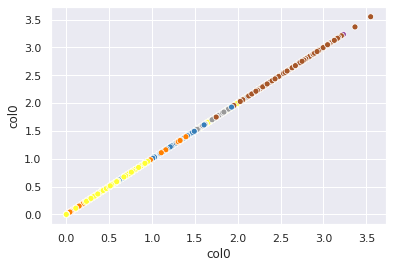

In [0]:
index = 0
ax = sns.scatterplot(x="col0", y="col" + str(index), hue="label", palette="Set1", legend=False,  data=cluster_pd)
print(index)

1


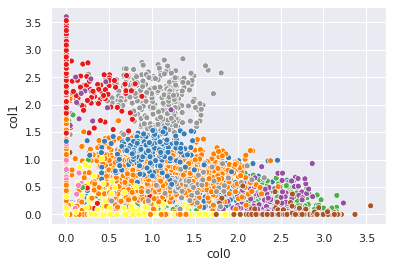

In [0]:
index += 1
print(index)
ax = sns.scatterplot(x="col0", y="col" + str(index), hue="label", palette="Set1", legend=False,  data=cluster_pd)

18


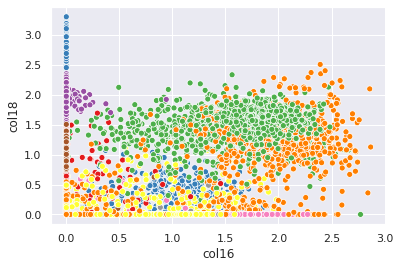

In [0]:
index += 1
print(index)
ax = sns.scatterplot(x="col16", y="col" + str(index), hue="label", palette="Set1", legend=False,  data=cluster_pd)

22


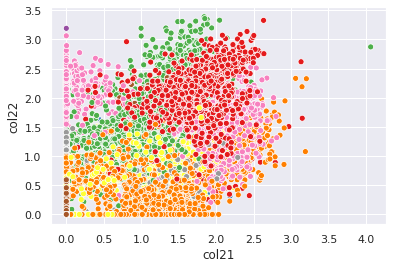

In [0]:
index += 1
print(index)
ax = sns.scatterplot(x="col21", y="col" + str(index), hue="label", palette="Set1", legend=False,  data=cluster_pd)

### PCA

In [0]:
from sklearn.decomposition import PCA

In [0]:
pca2 = PCA(n_components=2)
pca3 = PCA(n_components=3)

In [0]:
pca_dim2 = pca2.fit_transform(cluster_data)
pca_dim3 = pca3.fit_transform(cluster_data)

In [0]:
indices = []
for i in range(cluster_data.shape[0]):
    indices.append("sample" + str(i))

In [0]:
pca2_df = pd.DataFrame(data = pca_dim2, index = indices, columns = ['PCA1', 'PCA2'])
pca3_df = pd.DataFrame(data = pca_dim3, index = indices, columns = ['PCA1', 'PCA2', 'PCA3'])

In [0]:
cluster_labels_pd = pd.DataFrame(data=cluster_labels, index=indices, columns=["label"])

In [0]:
pca2_df2 = pd.concat([pca2_df, cluster_labels_pd], axis=1, sort=False)
pca3_df2 = pd.concat([pca3_df, cluster_labels_pd], axis=1, sort=False)

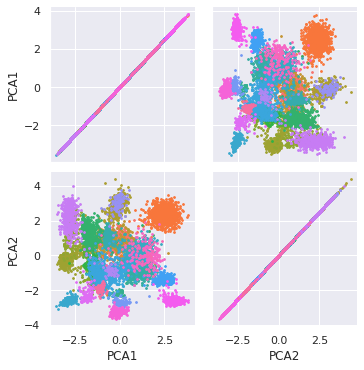

In [0]:
g = sns.PairGrid(pca2_df2, hue = 'label')
g.map(plt.scatter, s=3);

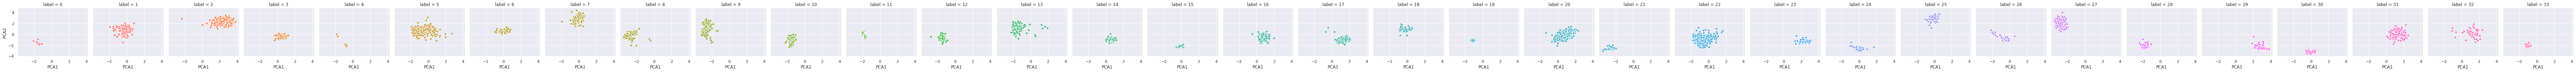

In [0]:
g = sns.FacetGrid(pca2_df2, col="label", hue="label")
g = (g.map(plt.scatter, "PCA1", "PCA2", edgecolor="w"))

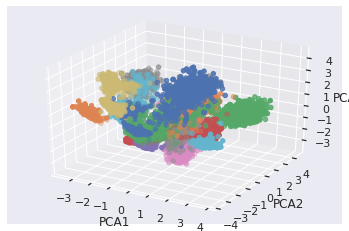

In [0]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

pca3_df3 = pca3_df2.groupby("label")

for name, group in pca3_df3:
    ax.scatter(group["PCA1"], group["PCA2"], group["PCA3"], marker="o", label=name)

ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')

plt.show()

### t-SNE

In [0]:
from sklearn.manifold import TSNE

In [0]:
tsne2 = TSNE(n_components=2)
tsne3 = TSNE(n_components=3)

In [0]:
tsne_dim2 = tsne2.fit_transform(cluster_data)
tsne_dim3 = tsne3.fit_transform(cluster_data)

In [0]:
indices = []
for i in range(cluster_data.shape[0]):
    indices.append("sample" + str(i))

In [0]:
tsne2_df = pd.DataFrame(data = tsne_dim2, index = indices, columns = ['TSNE1', 'TSNE2'])
tsne3_df = pd.DataFrame(data = tsne_dim3, index = indices, columns = ['TSNE1', 'TSNE2', "TSNE3"])

In [0]:
cluster_labels_pd = pd.DataFrame(data=cluster_labels, index=indices, columns=["label"])

In [0]:
tsne2_df2 = pd.concat([tsne2_df, cluster_labels_pd], axis=1, sort=False)
tsne3_df2 = pd.concat([tsne3_df, cluster_labels_pd], axis=1, sort=False)

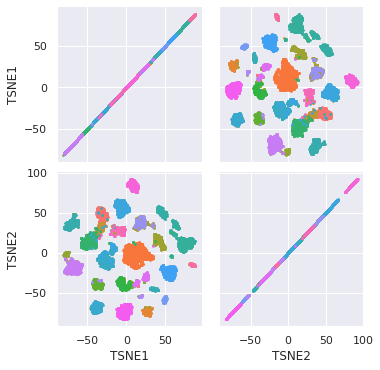

In [0]:
g = sns.PairGrid(tsne2_df2, hue = 'label')
g.map(plt.scatter, s=3);

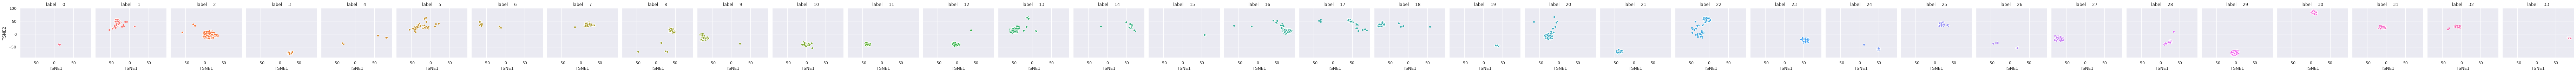

In [0]:
g = sns.FacetGrid(tsne2_df2, col="label", hue="label")
g = (g.map(plt.scatter, "TSNE1", "TSNE2", edgecolor="w"))

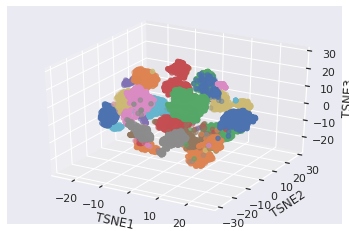

In [0]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

tsne3_df3 = tsne3_df2.groupby("label")

for name, group in tsne3_df3:
    ax.scatter(group["TSNE1"], group["TSNE2"], group["TSNE3"], marker="o", label=name)

ax.set_xlabel('TSNE1')
ax.set_ylabel('TSNE2')
ax.set_zlabel('TSNE3')

plt.show()